# Tiled Occlusion usage example

In [ ]:
%load_ext autoreload
%autoreload 2

Install required libraries (uncomment if you have not installed them yet) and example images.

If not in Linux, you can go manually to the websites below, download the files and add them to the folder `xai_assets`

In [ ]:
#!pip install torch torchvision captum "matplotlib<3.7"
!wget -P ./xai_assets https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
!wget -P ./xai_assets https://modernfarmer.com/wp-content/uploads/2021/05/shutterstock_339099548.jpg
!wget -P ./xai_assets https://cdn.pixabay.com/photo/2018/04/07/20/32/swan-3299528_1280.jpg

--2023-03-28 02:03:51--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.141.118, 52.216.94.141, 52.217.103.224, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.141.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: './xai_assets/imagenet_class_index.json.5'

100%[======================================>] 35,363      --.-K/s   in 0.09s   

2023-03-28 02:03:52 (389 KB/s) - './xai_assets/imagenet_class_index.json.5' saved [35363/35363]

--2023-03-28 02:03:52--  https://modernfarmer.com/wp-content/uploads/2021/05/shutterstock_339099548.jpg
Resolving modernfarmer.com (modernfarmer.com)... 104.26.11.85, 104.26.10.85, 172.67.73.28, ...
Connecting to modernfarmer.com (modernfarmer.com)|104.26.11.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: './xai_

Load required libraries

In [ ]:
from PIL import Image
from pathlib import Path
import os, json, numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torchvision import models, transforms
from captum.attr import NoiseTunnel, Occlusion, visualization as viz

Load ImageNet labels, load CNN, load pretrained weights, move CNN to GPU if possible

In [ ]:
labels_path = './xai_assets/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)
    
# Enable GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(f'Using {device=}')

#See full model list @ https://pytorch.org/vision/stable/models.html
def getCNN():
    #Get pretrained ImageNet CNN
    #model = models.resnet18(pretrained=True) #acc@1 69.758 | acc@5 89.078 | params 11.7M | GFLOPS 1.81
    model = models.efficientnet_b3(pretrained=True) #82.008 | 96.054 | 12.2M | 1.83
    model = model.eval().to(device)
    print(f'Using: {model.__class__}')
    return model
    
model= getCNN()

Using device=device(type='cuda', index=0)


/home/oscar/.conda/envs/oscar_earthnet/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/oscar/.conda/envs/oscar_earthnet/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using: <class 'torchvision.models.efficientnet.EfficientNet'>


Load and preprocess images. For now, we will only consider one image since the whole evaluation is extremely slow

Image 0
 - 1:  57.76%: cock
 - 2:  28.66%: hen
 - 3:  0.64%: partridge
 - 4:  0.06%: quail
 - 5:  0.05%: ostrich


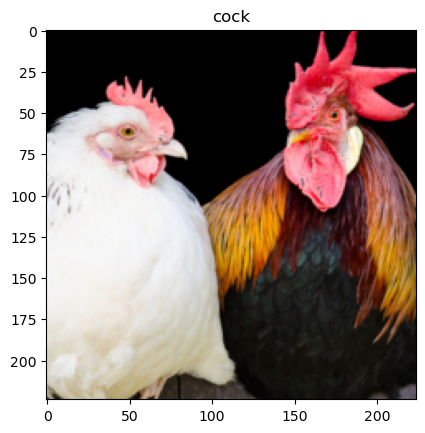

In [ ]:
#Define preprocessing functions
imagenet_mean, imagenet_std= [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor()])
transform_normalize = transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    
#Images -> tensors
images= []
for img in [
            #Image.open('./xai_assets/swan-3299528_1280.jpg'),
            Image.open('./xai_assets/shutterstock_339099548.jpg')
            ]:
    transformed_img= transform(img).to(device)
    images.append(transformed_img)
    
#Predict images using loaded CNN
predicted_indices= []
predicted_scores= []
for img in images:
    transformed_img= transform_normalize(img)[None]
    output = model(transformed_img)
    output = F.softmax(output, dim=1)
    prediction_scores, pred_label_idxs = torch.topk(output, 5)
    predicted_indices.append(pred_label_idxs)
    predicted_scores.append(prediction_scores)
    
    
#Plot all
for i, (img, idxs, scores) in enumerate(zip(images, predicted_indices, predicted_scores)):
    print(f'Image {i}')
    for k, (prediction_score, pred_label_idx) in list(enumerate(zip(scores.squeeze_(), 
                                                                    idxs.squeeze_()))):
        predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
        print(f' - {k+1}: {prediction_score.squeeze().item()*100 : 2.2f}%: {predicted_label}')
    
    plt.figure()
    plt.imshow(img.permute(1,2,0).cpu())
    plt.title(idx_to_labels[str(idxs.squeeze_()[0].item())][1])

Simple usage example:
 - The idea of the method is to combine the power of bigger occlusion patches while obtaining a high resolution smoother occlusion map, by adding occlusion results from several slightlhy shifted versions of the same input image
 - Notice that the interface of `TiledOcclusion` is shared with the rest of standard Captum attribution methods

100%|██████████| 4/4 [00:37<00:00,  9.47s/it]


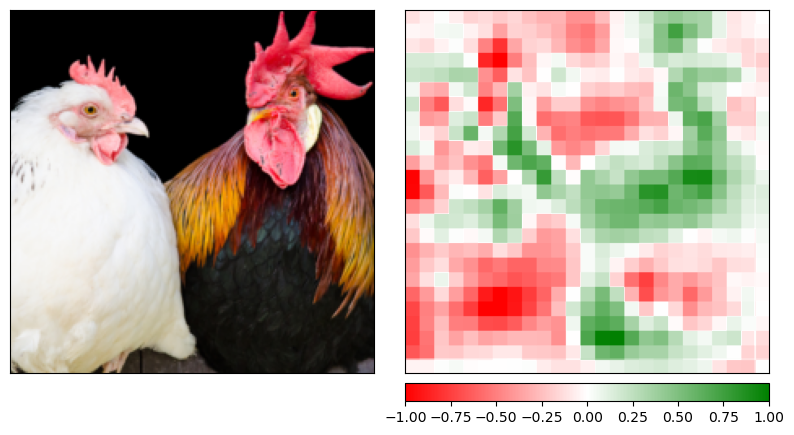

In [ ]:
from TiledOcclusion import TiledOcclusion
tiled_occlusion= TiledOcclusion(model)

for img, idxs in zip(images, predicted_indices):
    pred_label_idx= idxs.squeeze_()[0].item()
    label= idx_to_labels[str(pred_label_idx)][1]
    transformed_img= transform_normalize(img)[None]
    
    attributions_tocc= tiled_occlusion.attribute(transformed_img, target=pred_label_idx, k=[1,2,2], window= [3,18,18])
    _ = viz.visualize_image_attr_multiple(
          np.transpose(attributions_tocc.squeeze().cpu().detach().numpy(), (1,2,0)),
          np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
          ["original_image", "heat_map"], ["all", "all"], show_colorbar=True, outlier_perc=2)

Important notes about `TiledOcclusion`:
 - If we set `k = [1,1,1]`, it is the same as using standard `Occlusion`
 - By using higher values of `k`, the resolution of the attribution gets increased by that factor `k`
 - `TiledOcclusion` supports from 1D to 4D tensors (without counting the batch dimension)
 - It has been designed to share the interface with Captum, as such it is possible to use Captum's `NoiseTunnel(TiledOcclusion(model))` on top
 - The computational costs are exactly the same as for the standard `Occlusion` for a given output resolution

Now, we generate attributions using several configurations. In particular:
 - Both standard `TiledOcclusion` and `TiledOcclusion` + `NoiseTunnel` are tested
 - The attributions are computed for the two highest rating classes for each image
 - Several upscaling factors `k` are tested
 - Several windows for occluding are tested

100%|██████████| 1/1 [00:09<00:00,  9.95s/it]


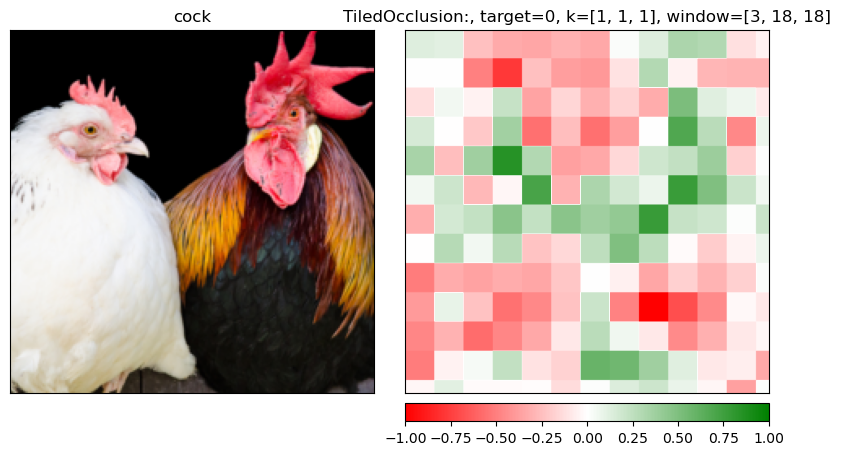

100%|██████████| 1/1 [00:19<00:00, 19.91s/it]


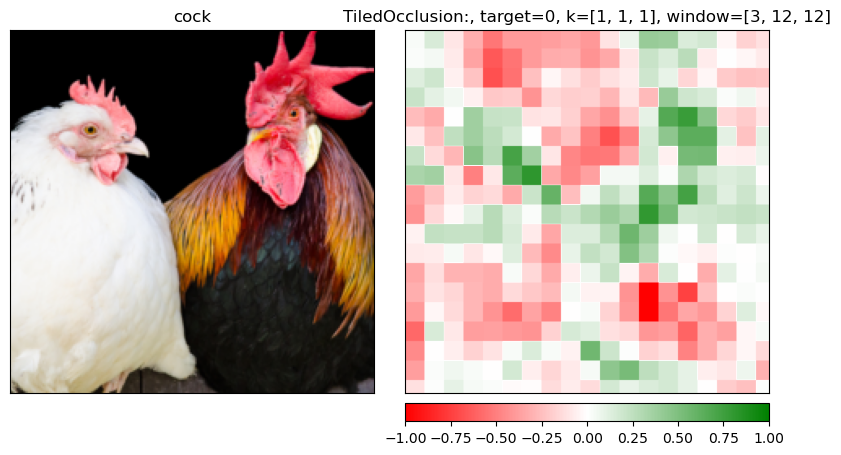

100%|██████████| 1/1 [00:34<00:00, 34.68s/it]


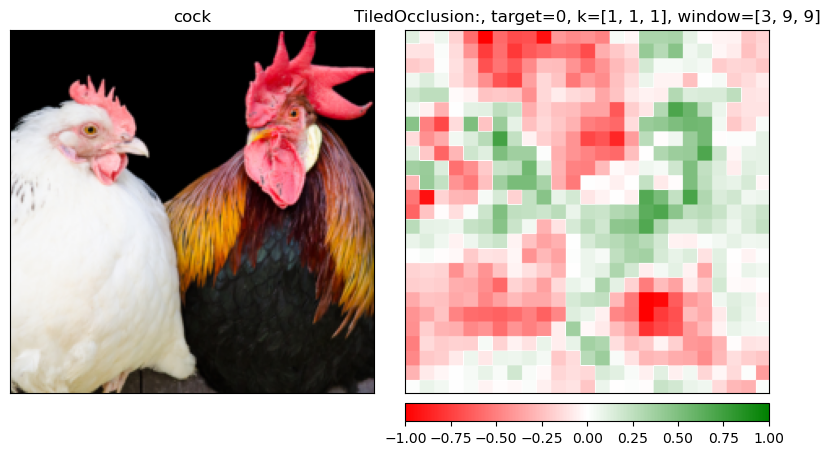

100%|██████████| 1/1 [01:20<00:00, 80.15s/it]


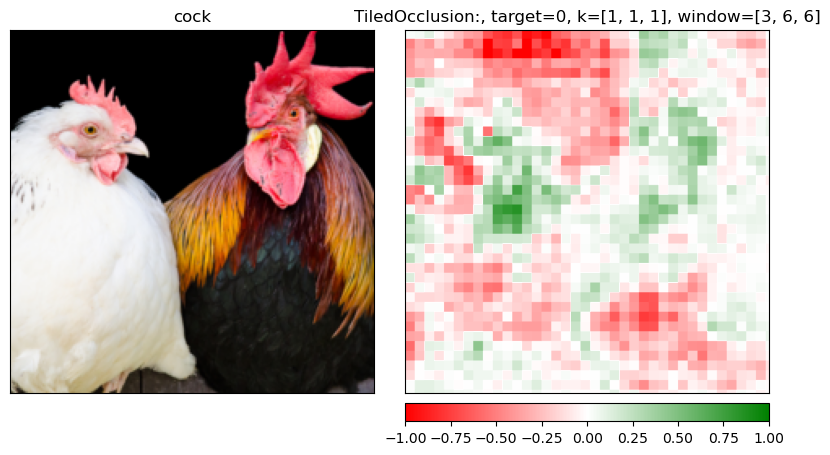

100%|██████████| 1/1 [02:51<00:00, 171.91s/it]


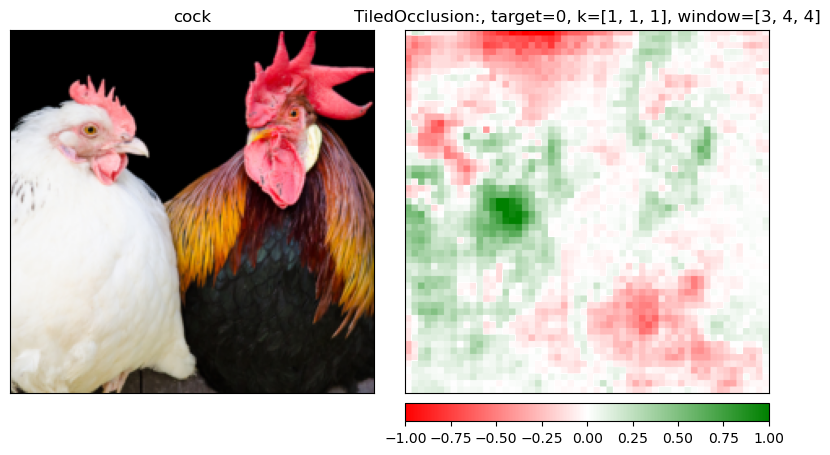

100%|██████████| 4/4 [00:37<00:00,  9.40s/it]


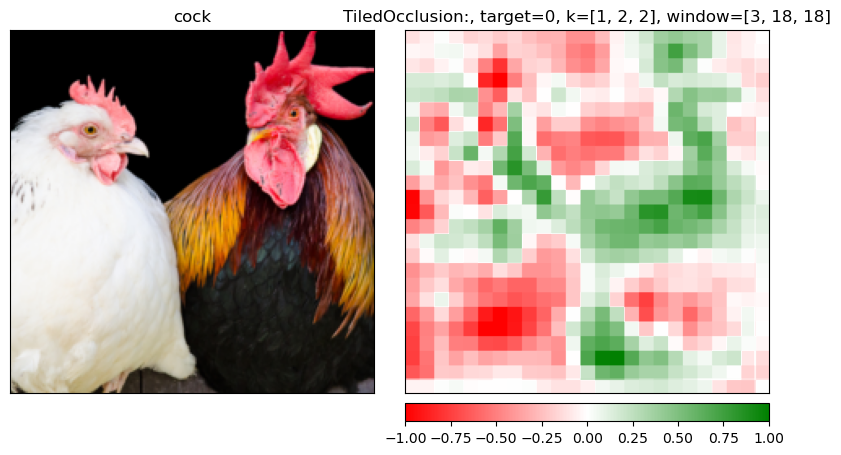

100%|██████████| 4/4 [01:20<00:00, 20.01s/it]


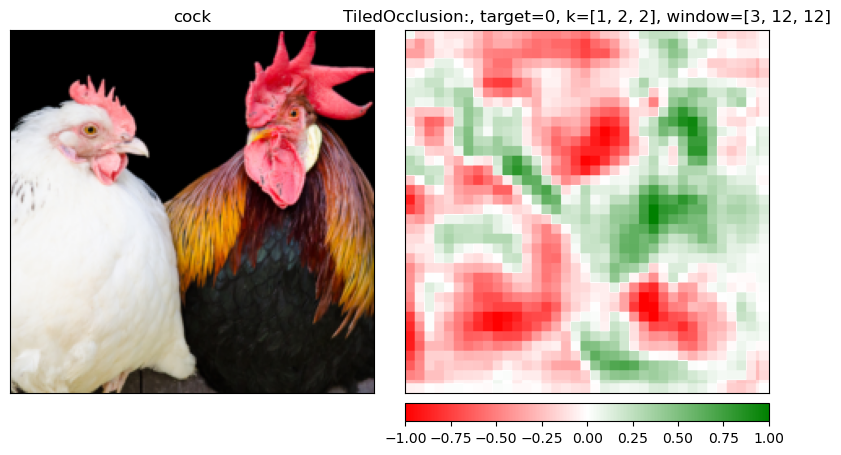

 89%|████████▉ | 8/9 [01:14<00:09,  9.34s/it]

In [ ]:
from itertools import product

for img, idxs in zip(images, predicted_indices):
    for method, target, k, window in product([TiledOcclusion(model), NoiseTunnel(TiledOcclusion(model))],
                                             [0, 1], [[1,1,1], [1,2,2], [1,3,3]], [[3,18,18], [3,12,12], [3,9,9], [3,6,6], [3,4,4]]):
        #Do not apply TiledOcclusion to very small windows
        if k[-1] != 1 and window[-1] <= 10: continue
        
        pred_label_idx= idxs.squeeze_()[target].item()
        label= idx_to_labels[str(pred_label_idx)][1]
        transformed_img= transform_normalize(img)[None]
        
        attributions_tocc= method.attribute(transformed_img, target=pred_label_idx, k=k, window=window)
        _ = viz.visualize_image_attr_multiple(
              np.transpose(attributions_tocc.squeeze().cpu().detach().numpy(), (1,2,0)),
              np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
              ["original_image", "heat_map"], ["all", "all"], show_colorbar=True, outlier_perc=2,
              titles=[f'{label}', f'{method.__class__.__name__}: {target=}, {k=}, {window=}'])